In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 3

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1103 (4.31 KB)
Trainable params: 1103 (4.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 1.4172 - accuracy: 0.3014
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 1s 20ms/step - loss: 1.4172 - accuracy: 0.3014 - val_loss: 1.0505 - val_accuracy: 0.5288
Epoch 2/1000
15/22 [===================>..........] - ETA: 0s - loss: 1.1619 - accuracy: 0.4302
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 1.1300 - accuracy: 0.4409 - val_loss: 0.9296 - val_accuracy: 0.4919
Epoch 3/1000
15/22 [===================>..........] - ETA: 0s - loss: 1.0407 - accuracy: 0.4734

/Users/joeymusante/dev/hand-remote/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 1.0343 - accuracy: 0.4703 - val_loss: 0.8583 - val_accuracy: 0.5494
Epoch 4/1000
14/22 [==================>...........] - ETA: 0s - loss: 0.9779 - accuracy: 0.4827
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 0.9768 - accuracy: 0.4873 - val_loss: 0.8115 - val_accuracy: 0.6069
Epoch 5/1000
14/22 [==================>...........] - ETA: 0s - loss: 0.9355 - accuracy: 0.5240
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 6ms/step - loss: 0.9246 - accuracy: 0.5264 - val_loss: 0.7807 - val_accuracy: 0.6634
Epoch 6/1000
16/22 [====================>.........] - ETA: 0s - loss: 0.9100 - accuracy: 0.5562
Epoch 6: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [=============

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.8371


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 39ms/step
[0.5534058  0.21256626 0.23402797]
0


# Confusion matrix

29/29 [==============================] - 0s 1ms/step


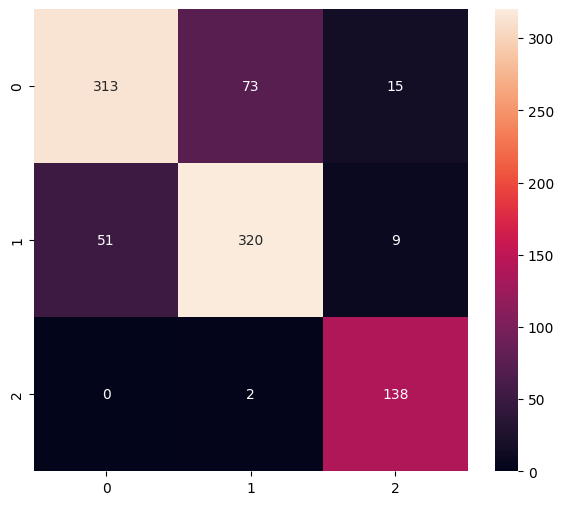

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       401
           1       0.81      0.84      0.83       380
           2       0.85      0.99      0.91       140

    accuracy                           0.84       921
   macro avg       0.84      0.87      0.85       921
weighted avg       0.84      0.84      0.84       921



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/Users/joeymusante/dev/hand-remote/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/9r/x_hzmzq51t15yvjk_3l8kzqh0000gn/T/tmp3gtzrcl3/assets


INFO:tensorflow:Assets written to: /var/folders/9r/x_hzmzq51t15yvjk_3l8kzqh0000gn/T/tmp3gtzrcl3/assets
2025-09-24 10:31:19.066756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-24 10:31:19.066766: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


6500

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 258 μs, sys: 295 μs, total: 553 μs
Wall time: 332 μs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.4608390e-04 9.9945396e-01 0.0000000e+00]
1


In [23]:
import tensorflow as tf

# Convert the trained model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save as .tflite file (overwrite the one the app uses)
with open("model/keypoint_classifier/keypoint_classifier.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/9r/x_hzmzq51t15yvjk_3l8kzqh0000gn/T/tmpfkqglp2s/assets


INFO:tensorflow:Assets written to: /var/folders/9r/x_hzmzq51t15yvjk_3l8kzqh0000gn/T/tmpfkqglp2s/assets
2025-09-24 10:31:19.508417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-24 10:31:19.508428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
